In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.callbacks import History
from tensorflow.keras.models import save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [3]:


def scale_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(np.array(df).reshape(-1, 1))
    return scaled_data



In [4]:
def split_data(data):
  training_size = int(len(data)*0.8)
  test_size = len(data) - training_size

  train_data = data[0:training_size, :]
  test_data = data[training_size:len(data), :1]

  return train_data, test_data, training_size, test_size

In [5]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step- 1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [6]:
def rnn_model(time_step = 100):
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(50))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

In [7]:
def train_model(model, X_train, y_train, X_test, y_test , epochs = 100, batch_size = 64):
  history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)
  return history

In [8]:

# def create_model(symbols, API_KEY):
#   for symbol in symbols:
#     url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}&outputsize=full&datatype=csv'

#     df = pd.read_csv(url)
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df.sort_values('timestamp', inplace=True)
#     data = df.reset_index()['close']

#     check = data.isnull().values.any()

#     if check:
#       data = data.dropna()

#     # scale data in range (0,1)
#     scaled_data = scale_data(data)

#     # split data
#     train_data, test_data, training_size, test_size = split_data(scaled_data)
#     # create data set
#     X_train , y_train = create_dataset(train_data, time_step)
#     X_test , y_test = create_dataset(test_data, time_step)


#     #reshape into 3d
#     X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
#     X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#     model = rnn_model(time_step)

#     history = train_model(model, X_train, y_train, X_test, y_test)

#     model.save(f"{symbol}_model.h5")

In [9]:
def fetch_stock_data(symbol, api_key):
    url = (
        f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY'
        f'&symbol={symbol}&apikey={api_key}&outputsize=full&datatype=csv'
    )
    df = pd.read_csv(url)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values('timestamp', inplace=True)
    return df.reset_index(drop=True)


def preprocess_data(df):
    data = df['close'].dropna().values
    return data

In [10]:

def prepare_and_train_model(symbol, api_key, time_step, epochs, batch_size):
    # Fetch and preprocess data
    df = fetch_stock_data(symbol, api_key)
    data = preprocess_data(df)

    # Scale data
    scaled_data = scale_data(data)

    # Split data into train and test
    train_data, test_data, training_size, test_size = split_data(scaled_data)

    # Create datasets for training/testing
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape inputs for RNN
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Create, train, and save model
    model = rnn_model(time_step)
    history = train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size)
    model.save(f"{symbol}_model.h5")
    print(f"Model saved for {symbol}")
    return history,


In [11]:
def main(symbols, api_key, time_step=100 , epochs=100, batch_size=64 ):
    histories ={}
    for symbol in symbols:
        try:
           print(f"Processing {symbol}")
           history = prepare_and_train_model(symbol, api_key, time_step, epochs, batch_size)
           histories[symbol] = history
        except Exception as e:
            print(f"Error processing {symbol}: {e}")
    return histories

In [ ]:


symbols = [ 'GOOGL', 'AMZN', 'NVDA','MSFT' , 'TSLA']

In [13]:
histories = main(symbols, API_KEY)

Processing GOOGL
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 0.0147 - val_loss: 0.0063
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - loss: 0.0010 - val_loss: 0.0070
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 8.9380e-04 - val_loss: 0.0048
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - loss: 8.6318e-04 - val_loss: 0.0049
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 7.6849e-04 - val_loss: 0.0043
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - loss: 9.0319e-04 - val_loss: 0.0043
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - loss: 6.9731e-04 - val_loss: 0.0041
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - loss: 5.6368e-04 - val_loss: 0.0040
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - loss: 6.4832e-04 - val_loss: 0.0038
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - loss: 6.1117e-04 - val_loss: 0.0053
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - loss: 6.9436e-04 - val_loss: 0.0040
Epoch 

Model saved for GOOGL
Processing AMZN
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - loss: 4.9869e-04 - val_loss: 0.0041
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - loss: 5.1580e-04 - val_loss: 0.0036
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 4.2933e-04 - val_loss: 0.0042
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - loss: 3.8968e-04 - val_loss: 0.0030
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 3.0965e-04 - val_loss: 0.0033
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - loss: 2.8726e-04 - val_loss: 0.0039
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 3.8498e-04 - val_loss: 0.0065
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - loss: 3.7458e-04 - val_loss: 0.0035
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 3.1135e-04 - val_loss: 0.0046
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 3.5046e-04 - val_loss: 0.0028
Ep

Model saved for AMZN
Processing NVDA
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - loss: 0.0012 - val_loss: 0.0070
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - loss: 1.2155e-04 - val_loss: 0.0067
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - loss: 1.0440e-04 - val_loss: 0.0069
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - loss: 9.9101e-05 - val_loss: 0.0055
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 8.6845e-05 - val_loss: 0.0054
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - loss: 8.8311e-05 - val_loss: 0.0051
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - loss: 8.0929e-05 - val_loss: 0.0048
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - loss: 8.3000e-05 - val_loss: 0.0049
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 7.6927e-05 - val_loss: 0.0044
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - loss: 7.0147e-05 - val_loss: 0.0046
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - loss: 7.2503e-05 - val_loss: 0.0041
Ep

Model saved for NVDA
Processing MSFT
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - loss: 1.5669e-04 - val_loss: 0.0025
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - loss: 1.1049e-04 - val_loss: 0.0020
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - loss: 1.1846e-04 - val_loss: 8.8659e-04
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - loss: 9.7054e-05 - val_loss: 0.0024
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 1.0138e-04 - val_loss: 6.6088e-04
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - loss: 9.3185e-05 - val_loss: 0.0012
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 8.1982e-05 - val_loss: 7.2273e-04
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - loss: 8.0572e-05 - val_loss: 0.0011
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 8.5573e-05 - val_loss: 5.4876e-04
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - loss: 7.3751e-05 - val

Model saved for MSFT
Processing TSLA
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - loss: 0.0098 - val_loss: 2.9055e-04
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - loss: 0.0019 - val_loss: 1.6738e-04
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 0.0022 - val_loss: 1.6417e-04
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 0.0015 - val_loss: 1.6410e-04
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 0.0016 - val_loss: 2.1496e-04
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - loss: 0.0014 - val_loss: 2.3047e-04
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 0.0018 - val_loss: 1.3084e-04
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 0.0015 - val_loss: 1.1220e-04
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - loss: 0.0015 - val_loss: 4.9724e-04
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 0.0012 - val_loss: 8.4544e-05
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0011 - val_loss: 2.2167e-04
E

Model saved for TSLA


In [14]:
def plot_loss_graphs(histories):
    plt.figure(figsize=(10, 6))

    for symbol, history in histories.items():
        loss = history.history['loss']
        val_loss = history.history.get('val_loss', None)

        plt.plot(loss, label=f'{symbol} Train Loss')
        if val_loss:
            plt.plot(val_loss, linestyle='--', label=f'{symbol} Val Loss')
        plt.title('Training and Validation Loss per Symbol')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



In [ ]:
plot_loss_graphs(histories)

In [ ]:
symbol = 'MSFT'


url = (
        f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY'
        f'&symbol={symbol}&apikey={API_KEY}&outputsize=full&datatype=csv'
    )
df = pd.read_csv(url)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values('timestamp', inplace=True)


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('MSFT_model.h5')

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = scaler.inverse_transform(y_predicted)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'APPL - Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual Price')
plt.plot(y_predicted, label='Predicted Price')
plt.title('Appl - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
total_loss = history.history['loss'] + history_2.history['loss']

# Combine validation losses (if used)
if 'val_loss' in history.history:
    total_val_loss = history.history['val_loss'] + history_2.history['val_loss']
else:
    total_val_loss = None

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(total_loss, label='Training Loss')
plt.plot(total_val_loss, label='Validation Loss')
plt.title('Combined Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_predicted2 = model.predict(X_test)
y_predicted2 = scaler.inverse_transform(y_predicted2)
y_actual2 = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_actual2, label='Actual Price')
plt.plot(y_predicted2, label='Predicted Price')
plt.title('Appl - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np

# MAPE = mean(|(actual - predicted)/actual|) * 100
mape = np.mean(np.abs((y_actual2 - y_predicted2) / y_actual2)) * 100
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy (approx): {accuracy:.2f}%")

In [ ]:
model.save("AAPL_model.h5")

In [ ]:
from google.colab import files
files.download("MSFT_model.h5")

In [ ]:
!ls

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('GOOGL_model.h5')

In [28]:
def fetch_stock_data(symbol, api_key):
    url = (
        f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY'
        f'&symbol={symbol}&apikey={api_key}&outputsize=full&datatype=csv'
    )
    df = pd.read_csv(url)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values('timestamp', inplace=True)
    return df.reset_index(drop=True)


def preprocess_data(df):
    data = df['close'].dropna().values
    return data

In [60]:
data = fetch_stock_data( 'GOOGL', API_KEY)

In [61]:
data

,timestamp,open,high,low,close,volume
0,2004-08-19,100.010,104.060,95.96,100.335,44659000
1,2004-08-20,101.010,109.080,100.50,108.310,22834300
2,2004-08-23,110.760,113.480,109.05,109.400,18256100
3,2004-08-24,111.240,111.600,103.57,104.870,15247300
4,2004-08-25,104.760,108.000,103.88,106.000,9188600
...,...,...,...,...,...,...
5262,2025-07-21,186.250,190.285,186.15,190.100,45803129
5263,2025-07-22,191.495,191.645,187.46,191.340,44660215
5264,2025-07-23,191.500,192.530,189.18,190.230,58681948
5265,2025-07-24,197.030,197.950,191.00,192.170,74881687


In [70]:
data1 = preprocess_data(data)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data1.reshape(-1, 1))


train_data, test_data, training_size, test_size = split_data(scaled_data)

# Create datasets for training/testing
X_train, y_train = create_dataset(train_data, 100)
X_test, y_test = create_dataset(test_data, 100)




In [73]:
# Reshape inputs for RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


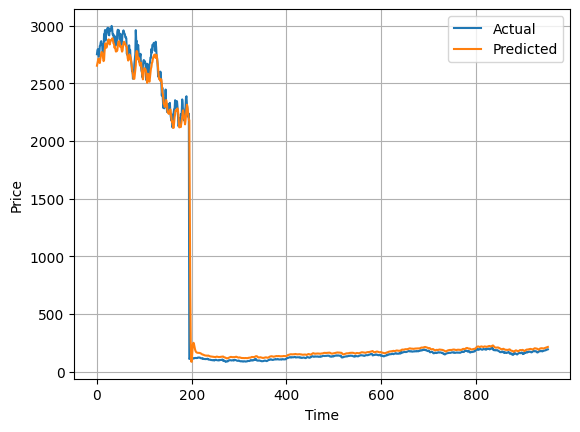

In [74]:
test_predict=model.predict(X_test)
y_predicted = scaler.inverse_transform(test_predict)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # ytest is your true test labels

# Plot

plt.plot(y_actual, label='Actual')
plt.plot(y_predicted, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [77]:

y_predicted = model.predict(X_test)
y_predicted = scaler.inverse_transform(y_predicted)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


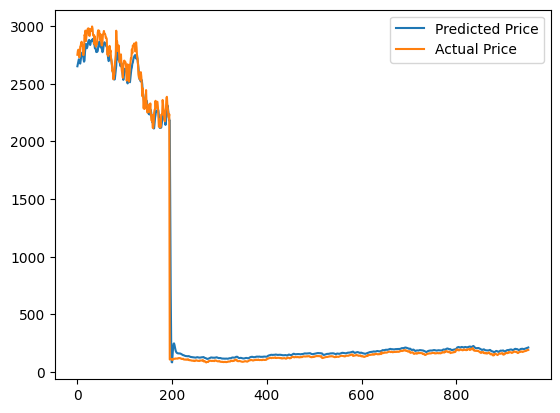

In [78]:
plt.plot(y_predicted, label='Predicted Price')
plt.plot(y_test, label='Actual Price')
plt.legend()
plt.show()

In [87]:
x_input = scaled_data[-100:].reshape(1,100,1)

In [88]:
x_input

array([[[0.03003082],
        [0.03075165],
        [0.03052167],
        [0.03103997],
        [0.02829742],
        [0.02766927],
        [0.02872305],
        [0.02722991],
        [0.02816698],
        [0.02775509],
        [0.02651253],
        [0.02761779],
        [0.02724364],
        [0.02765211],
        [0.0289187 ],
        [0.02990725],
        [0.02801939],
        [0.02705143],
        [0.02433633],
        [0.02444274],
        [0.02527683],
        [0.02526653],
        [0.0230972 ],
        [0.02133977],
        [0.0217345 ],
        [0.02103084],
        [0.02583976],
        [0.02381802],
        [0.02530086],
        [0.02596333],
        [0.02501596],
        [0.02399308],
        [0.02324823],
        [0.02205029],
        [0.02335464],
        [0.02468644],
        [0.02603541],
        [0.02695532],
        [0.02649193],
        [0.02633747],
        [0.02587065],
        [0.02672877],
        [0.02766584],
        [0.02772763],
        [0.02739124],
        [0

In [89]:
y_next = model.predict(x_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [90]:
y_next = scaler.inverse_transform(y_next)

In [91]:
y_next

array([[215.1149]], dtype=float32)

In [92]:
mape = np.mean(np.abs((y_test - y_predicted) / y_test)) * 100
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy (approx): {accuracy:.2f}%")

MAPE: 20.48%
Accuracy (approx): 79.52%
